In [ ]:
"""Original: momemntum = 0.5 to 0.8, learning rate=500, max_iter_thresh=20
Exp01: momemntum = 0.1 to 0.8, learning rate=500, max_iter_thresh=20, max_iter = 1000
Exp02: momemntum = 0.1 to 0.5, learning rate=500, max_iter_thresh=20, max_iter = 1000
Exp03: momemntum = 0.1 to 1, learning rate=500, max_iter_thresh=20, max_iter = 1000
Exp04: momemntum = 1 to 2, learning rate=500, max_iter_thresh=20, max_iter = 1000 --> Runs into warning (divide by zero encountered in true_divide)
Exp05: momemntum = 0.1 to 2, learning rate=500, max_iter_thresh=20, max_iter = 1000 --> Runs into warning (divide by zero encountered in true_divide)
Exp06: momemntum = 0.5 to 0.8, learning rate=500, max_iter_thresh=250, max_iter = 1000
Exp07: momemntum = 0.5 to 0.8, learning rate=500, max_iter_thresh=250, max_iter = 500
Exp08: momemntum = 0.5 to 0.8, learning rate=500, max_iter_thresh=20, max_iter = 500
Exp09: momemntum = 0.5 to 0.8, learning rate=500, max_iter_thresh=20, max_iter = 1500
Exp10: momemntum = 0.5 to 0.8, learning rate=500, max_iter_thresh=20, max_iter = 2000
Exp11: momemntum = 0.5 to 0.8, learning rate=100, max_iter_thresh=20, max_iter = 1000
Exp12: momemntum = 0.5 to 0.8, learning rate=50, max_iter_thresh=20, max_iter = 1000
Exp13: momemntum = 0.5 to 0.8, learning rate=250, max_iter_thresh=20, max_iter = 1000"""

In [1]:
import keras
import numpy as np
from sklearn import datasets
%matplotlib inline                                 
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace  
import pandas as pd
import seaborn as sns
import os
import pylab

np.random.seed(1234)

In [2]:
X = np.loadtxt("mnist2500_X.txt")
labels = np.loadtxt("mnist2500_labels.txt")

In [3]:
print(X.shape, labels.shape)
print(np.amin(X), np.amax(X))
print(labels)

(2500, 784) (2500,)
0.0 1.0
[5. 0. 4. ... 1. 6. 2.]


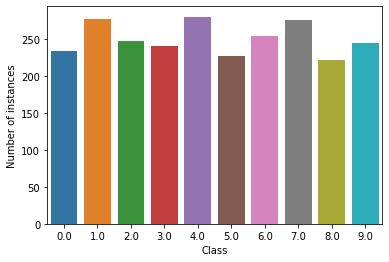

In [4]:
df = pd.DataFrame(data=labels, columns=['class'])
ax = sns.countplot(x='class', data=df)
ax.set(xlabel='Class', ylabel='Number of instances')
plt.show()

In [6]:
def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000 #The number of gradient descent iterations T
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.573319
Iteration 10: error is 22.126834
Iteration 20: error is 19.771739
Iteration 30: error is 17.259893
Iteration 40: error is 16.411116
Iteration 50: error is 16.140814
Iteration 60: error is 16.042986
Iteration 70: error is 15.954113
Iteration 80: error is 15.873883
Iteration 90: error is 15.811019
Iteration 100: error is 15.787737
Iteration 110: error is 2.266494
Iteration 120: error is 1.958884
Iteration 130: error is 1.760830
Iteration 140: error is 1.625566
Iteration 150: error is 1.528302
Iteration 160: error is 1.454991
Iteration 170: error is 1.397361
It

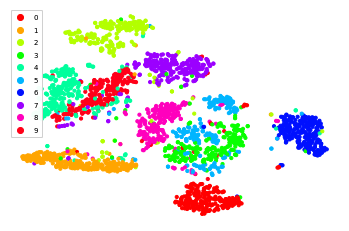

Wall time: 9min 22s


In [7]:
%%time
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    Y = tsne(X, 2, 50, perplexity=30.0)
    fig, ax = plt.subplots()
    scatter = ax.scatter(Y[:, 0], Y[:, 1], s=10, c=labels, cmap='hsv')
    plt.axis('off')
    legend = ax.legend(*scatter.legend_elements(), fontsize=7)
    ax.add_artist(legend)
    plt.show()

In [20]:
def tsne_exp2(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000 #The number of gradient descent iterations T
    initial_momentum = 0.1
    final_momentum = 0.5
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.573319
Iteration 10: error is 22.167892
Iteration 20: error is 19.949730
Iteration 30: error is 18.046619
Iteration 40: error is 17.059489
Iteration 50: error is 16.593556
Iteration 60: error is 16.304954
Iteration 70: error is 16.113598
Iteration 80: error is 15.976254
Iteration 90: error is 15.874055
Iteration 100: error is 15.798293
Iteration 110: error is 2.292275
Iteration 120: error is 2.069866
Iteration 130: error is 1.902450
Iteration 140: error is 1.773896
Iteration 150: error is 1.673469
Iteration 160: error is 1.593255
Iteration 170: error is 1.527675
It

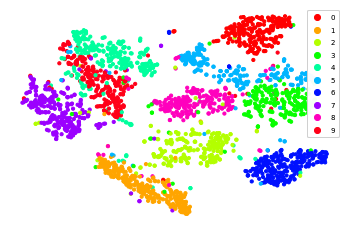

Wall time: 9min 12s


In [22]:
%%time
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    Y = tsne_exp2(X, 2, 50, perplexity=30.0)
    fig, ax = plt.subplots()
    scatter = ax.scatter(Y[:, 0], Y[:, 1], s=10, c=labels, cmap='hsv')
    plt.axis('off')
    legend = ax.legend(*scatter.legend_elements(), fontsize=7)
    ax.add_artist(legend)
    plt.show()

In [10]:
#initial and final parameter changed
def tsne_exp1(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000 #The number of gradient descent iterations T
    initial_momentum = 0.1
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.573319
Iteration 10: error is 22.019966
Iteration 20: error is 19.765176
Iteration 30: error is 17.258203
Iteration 40: error is 16.264854
Iteration 50: error is 15.942787
Iteration 60: error is 15.765699
Iteration 70: error is 15.662225
Iteration 80: error is 15.595971
Iteration 90: error is 15.555963
Iteration 100: error is 15.533828
Iteration 110: error is 2.183590
Iteration 120: error is 1.886176
Iteration 130: error is 1.695967
Iteration 140: error is 1.566644
Iteration 150: error is 1.473178
Iteration 160: error is 1.401652
Iteration 170: error is 1.345699
It

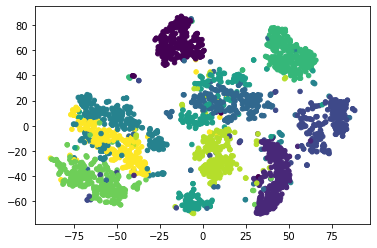

Wall time: 12min 8s


In [11]:
%%time
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    Y = tsne_exp1(X, 2, 50, perplexity=30.0)
    pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
    pylab.show()

In [23]:
#initial and final parameter changed
def tsne_exp3(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000 #The number of gradient descent iterations T
    initial_momentum = 0.1
    final_momentum = 1
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.573319
Iteration 10: error is 22.003784
Iteration 20: error is 19.600667
Iteration 30: error is 16.118301
Iteration 40: error is 14.004262
Iteration 50: error is 13.538178
Iteration 60: error is 13.689466
Iteration 70: error is 13.823189
Iteration 80: error is 14.056247
Iteration 90: error is 14.214871
Iteration 100: error is 14.249061
Iteration 110: error is 1.945983
Iteration 120: error is 1.567116
Iteration 130: error is 1.387787
Iteration 140: error is 1.301084
Iteration 150: error is 1.249637
Iteration 160: error is 1.219711
Iteration 170: error is 1.207842
It

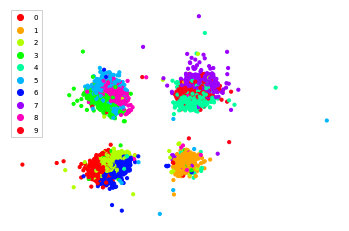

Wall time: 9min 15s


In [24]:
%%time
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    Y = tsne_exp3(X, 2, 50, perplexity=30.0)
    fig, ax = plt.subplots()
    scatter = ax.scatter(Y[:, 0], Y[:, 1], s=10, c=labels, cmap='hsv')
    plt.axis('off')
    legend = ax.legend(*scatter.legend_elements(), fontsize=7)
    ax.add_artist(legend)
    plt.show()

In [14]:
#initial and final parameter changed
def tsne_exp4(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000 #The number of gradient descent iterations T
    initial_momentum = 1
    final_momentum = 2
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.573319
Iteration 10: error is 23.675963
Iteration 20: error is 22.899584
Iteration 30: error is 29.581325
Iteration 40: error is 29.836281


C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide


Iteration 50: error is 29.836484
Iteration 60: error is 29.836484
Iteration 70: error is 29.836484
Iteration 80: error is 29.836484
Iteration 90: error is 29.836484
Iteration 100: error is 29.836484
Iteration 110: error is 6.072827
Iteration 120: error is 6.072827
Iteration 130: error is 6.072827
Iteration 140: error is 6.072827
Iteration 150: error is 6.072827
Iteration 160: error is 6.072827
Iteration 170: error is 6.072827
Iteration 180: error is 6.072827
Iteration 190: error is 6.072827
Iteration 200: error is 6.072827
Iteration 210: error is 6.072827
Iteration 220: error is 6.072827
Iteration 230: error is 6.072827
Iteration 240: error is 6.072827
Iteration 250: error is 6.072827
Iteration 260: error is 6.072827
Iteration 270: error is 6.072827
Iteration 280: error is 6.072827
Iteration 290: error is 6.072827
Iteration 300: error is 6.072827
Iteration 310: error is 6.072827
Iteration 320: error is 6.072827
Iteration 330: error is 6.072827
Iteration 340: error is 6.072827
Iteration

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in multiply
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in add
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in square
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in add
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in greater
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Iteration 540: error is nan
Iteration 550: error is nan
Iteration 560: error is nan
Iteration 570: error is nan
Iteration 580: error is nan
Iteration 590: error is nan
Iteration 600: error is nan
Iteration 610: error is nan
Iteration 620: error is nan
Iteration 630: error is nan
Iteration 640: error is nan
Iteration 650: error is nan
Iteration 660: error is nan
Iteration 670: error is nan
Iteration 680: error is nan
Iteration 690: error is nan
Iteration 700: error is nan
Iteration 710: error is nan
Iteration 720: error is nan
Iteration 730: error is nan
Iteration 740: error is nan
Iteration 750: error is nan
Iteration 760: error is nan
Iteration 770: error is nan
Iteration 780: error is nan
Iteration 790: error is nan
Iteration 800: error is nan
Iteration 810: error is nan
Iteration 820: error is nan
Iteration 830: error is nan
Iteration 840: error is nan
Iteration 850: error is nan
Iteration 860: error is nan
Iteration 870: error is nan
Iteration 880: error is nan
Iteration 890: error

C:\Users\Admin\Anaconda3\lib\site-packages\matplotlib\colors.py:933: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\ma\core.py:713: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


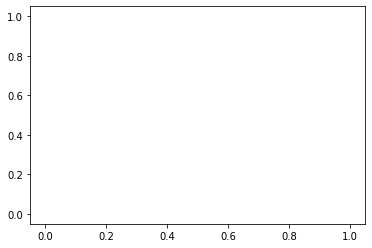

Wall time: 10min 52s


In [15]:
%%time
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    Y = tsne_exp4(X, 2, 50, perplexity=30.0)
    pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
    pylab.show()

In [16]:
#initial and final parameter changed
def tsne_exp5(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000 #The number of gradient descent iterations T
    initial_momentum = 0.1
    final_momentum = 2
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.573319
Iteration 10: error is 22.080406
Iteration 20: error is 19.609572
Iteration 30: error is 16.599059
Iteration 40: error is 18.219287


C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide


Iteration 50: error is 18.215650
Iteration 60: error is 18.215647
Iteration 70: error is 18.215647
Iteration 80: error is 18.215647
Iteration 90: error is 18.215647
Iteration 100: error is 18.215647
Iteration 110: error is 3.167617
Iteration 120: error is 3.167617
Iteration 130: error is 3.167617
Iteration 140: error is 3.167617
Iteration 150: error is 3.167617
Iteration 160: error is 3.167617
Iteration 170: error is 3.167617
Iteration 180: error is 3.167617
Iteration 190: error is 3.167617
Iteration 200: error is 3.167617
Iteration 210: error is 3.167617
Iteration 220: error is 3.167617
Iteration 230: error is 3.167617
Iteration 240: error is 3.167617
Iteration 250: error is 3.167617
Iteration 260: error is 3.167617
Iteration 270: error is 3.167617
Iteration 280: error is 3.167617
Iteration 290: error is 3.167617
Iteration 300: error is 3.167617
Iteration 310: error is 3.167617
Iteration 320: error is 3.167617
Iteration 330: error is 3.167617
Iteration 340: error is 3.167617
Iteration

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in add
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in square
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in multiply
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in add
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in greater
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


Iteration 540: error is nan
Iteration 550: error is nan
Iteration 560: error is nan
Iteration 570: error is nan
Iteration 580: error is nan
Iteration 590: error is nan
Iteration 600: error is nan
Iteration 610: error is nan
Iteration 620: error is nan
Iteration 630: error is nan
Iteration 640: error is nan
Iteration 650: error is nan
Iteration 660: error is nan
Iteration 670: error is nan
Iteration 680: error is nan
Iteration 690: error is nan
Iteration 700: error is nan
Iteration 710: error is nan
Iteration 720: error is nan
Iteration 730: error is nan
Iteration 740: error is nan
Iteration 750: error is nan
Iteration 760: error is nan
Iteration 770: error is nan
Iteration 780: error is nan
Iteration 790: error is nan
Iteration 800: error is nan
Iteration 810: error is nan
Iteration 820: error is nan
Iteration 830: error is nan
Iteration 840: error is nan
Iteration 850: error is nan
Iteration 860: error is nan
Iteration 870: error is nan
Iteration 880: error is nan
Iteration 890: error

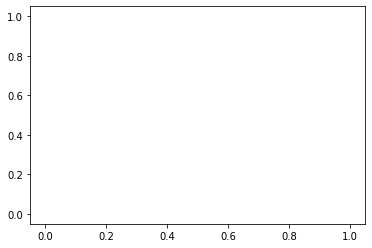

Wall time: 11min


In [17]:
%%time
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    Y = tsne_exp5(X, 2, 50, perplexity=30.0)
    pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
    pylab.show()

In [18]:
#max iter threshold from 20(script) to 250(manuscript)
def tsne_exp6(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000 #The number of gradient descent iterations T
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 250:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.573319
Iteration 10: error is 22.115800
Iteration 20: error is 19.608836
Iteration 30: error is 17.730396
Iteration 40: error is 16.988034
Iteration 50: error is 16.560731
Iteration 60: error is 16.276104
Iteration 70: error is 16.092673
Iteration 80: error is 15.963368
Iteration 90: error is 15.864532
Iteration 100: error is 15.789821
Iteration 110: error is 2.288039
Iteration 120: error is 2.064430
Iteration 130: error is 1.896476
Iteration 140: error is 1.768781
Iteration 150: error is 1.669109
Iteration 160: error is 1.589437
Iteration 170: error is 1.524293
It

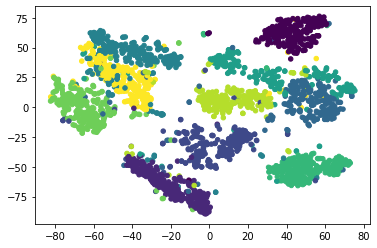

Wall time: 13min 18s


In [19]:
%%time
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    Y = tsne_exp6(X, 2, 50, perplexity=30.0)
    pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
    pylab.show()

In [20]:
#total number of iter, and iter_threshold

def tsne_exp7(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 500 #The number of gradient descent iterations T
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 250:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.573319
Iteration 10: error is 21.922075
Iteration 20: error is 19.127328
Iteration 30: error is 17.507072
Iteration 40: error is 16.829460
Iteration 50: error is 16.423295
Iteration 60: error is 16.179516
Iteration 70: error is 16.014798
Iteration 80: error is 15.897697
Iteration 90: error is 15.810655
Iteration 100: error is 15.744937
Iteration 110: error is 2.279406
Iteration 120: error is 2.058424
Iteration 130: error is 1.893869
Iteration 140: error is 1.767595
Iteration 150: error is 1.667976
Iteration 160: error is 1.588357
Iteration 170: error is 1.523254
It

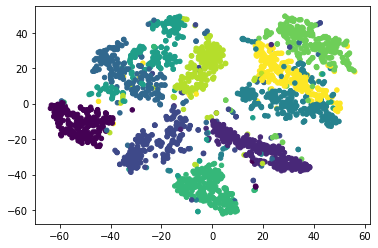

Wall time: 5min 34s


In [21]:
%%time
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    Y = tsne_exp7(X, 2, 50, perplexity=30.0)
    pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
    pylab.show()

In [22]:
#total number of iter

def tsne_exp8(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 500 #The number of gradient descent iterations T
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.573319
Iteration 10: error is 22.130968
Iteration 20: error is 19.706559
Iteration 30: error is 16.958895
Iteration 40: error is 16.114421
Iteration 50: error is 15.868588
Iteration 60: error is 15.795726
Iteration 70: error is 15.733223
Iteration 80: error is 15.682563
Iteration 90: error is 15.642299
Iteration 100: error is 15.617345
Iteration 110: error is 2.212047
Iteration 120: error is 1.912277
Iteration 130: error is 1.716478
Iteration 140: error is 1.584118
Iteration 150: error is 1.489251
Iteration 160: error is 1.417591
Iteration 170: error is 1.361477
It

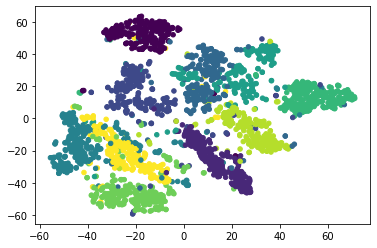

Wall time: 6min 25s


In [23]:
%%time
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    Y = tsne_exp8(X, 2, 50, perplexity=30.0)
    pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
    pylab.show()

In [8]:
#total number of iter

def tsne_exp9(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1500 #The number of gradient descent iterations T
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.573319
Iteration 10: error is 22.162202
Iteration 20: error is 20.179806
Iteration 30: error is 17.225935
Iteration 40: error is 16.119333
Iteration 50: error is 15.810175
Iteration 60: error is 15.675883
Iteration 70: error is 15.640604
Iteration 80: error is 15.626693
Iteration 90: error is 15.622787
Iteration 100: error is 15.621422
Iteration 110: error is 2.198867
Iteration 120: error is 1.906374
Iteration 130: error is 1.716669
Iteration 140: error is 1.587208
Iteration 150: error is 1.493126
Iteration 160: error is 1.421041
Iteration 170: error is 1.364763
It

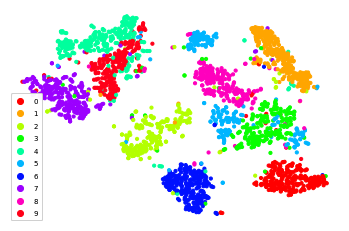

In [9]:
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    Y = tsne_exp9(X, 2, 50, perplexity=30.0)
    fig, ax = plt.subplots()
    scatter = ax.scatter(Y[:, 0], Y[:, 1], s=10, c=labels, cmap='hsv')
    plt.axis('off')
    legend = ax.legend(*scatter.legend_elements(), fontsize=7)
    ax.add_artist(legend)
    plt.show()

In [10]:
#total number of iter

def tsne_exp10(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1500 #The number of gradient descent iterations T
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.573319
Iteration 10: error is 21.942924
Iteration 20: error is 19.306073
Iteration 30: error is 16.730619
Iteration 40: error is 15.919703
Iteration 50: error is 15.682785
Iteration 60: error is 15.593286
Iteration 70: error is 15.539185
Iteration 80: error is 15.511915
Iteration 90: error is 15.500307
Iteration 100: error is 15.497074
Iteration 110: error is 2.183610
Iteration 120: error is 1.894379
Iteration 130: error is 1.703255
Iteration 140: error is 1.572116
Iteration 150: error is 1.476495
Iteration 160: error is 1.404421
Iteration 170: error is 1.348083
It

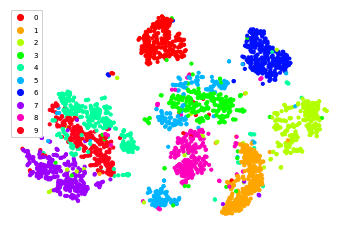

In [11]:
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    Y = tsne_exp10(X, 2, 50, perplexity=30.0)
    fig, ax = plt.subplots()
    scatter = ax.scatter(Y[:, 0], Y[:, 1], s=10, c=labels, cmap='hsv')
    plt.axis('off')
    legend = ax.legend(*scatter.legend_elements(), fontsize=7)
    ax.add_artist(legend)
    plt.show()

In [13]:
#learning rate org(100) from script(500) changed
def tsne_exp11(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000 #The number of gradient descent iterations T
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 100
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.573319
Iteration 10: error is 22.425415
Iteration 20: error is 22.185828
Iteration 30: error is 20.269879
Iteration 40: error is 18.252077
Iteration 50: error is 17.290464
Iteration 60: error is 16.772606
Iteration 70: error is 16.417605
Iteration 80: error is 16.134639
Iteration 90: error is 15.916518
Iteration 100: error is 15.770848
Iteration 110: error is 2.266481
Iteration 120: error is 2.015112
Iteration 130: error is 1.860372
Iteration 140: error is 1.752725
Iteration 150: error is 1.670495
Iteration 160: error is 1.604832
Iteration 170: error is 1.550924
It

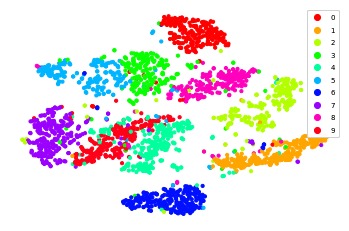

In [14]:
#Run original script parameters
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    Y = tsne_exp11(X, 2, 50, perplexity=30.0)
    fig, ax = plt.subplots()
    scatter = ax.scatter(Y[:, 0], Y[:, 1], s=10, c=labels, cmap='hsv')
    plt.axis('off')
    legend = ax.legend(*scatter.legend_elements(), fontsize=7)
    ax.add_artist(legend)
    plt.show()

In [15]:
#learning rate 50 from script(500) changed
def tsne_exp12(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000 #The number of gradient descent iterations T
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 50
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.573319
Iteration 10: error is 22.952259
Iteration 20: error is 22.300875
Iteration 30: error is 21.880789
Iteration 40: error is 20.796245
Iteration 50: error is 19.593023
Iteration 60: error is 18.629253
Iteration 70: error is 18.001130
Iteration 80: error is 17.477642
Iteration 90: error is 17.057462
Iteration 100: error is 16.754817
Iteration 110: error is 2.553178
Iteration 120: error is 2.295284
Iteration 130: error is 2.127493
Iteration 140: error is 2.007036
Iteration 150: error is 1.913753
Iteration 160: error is 1.837815
Iteration 170: error is 1.774027
It

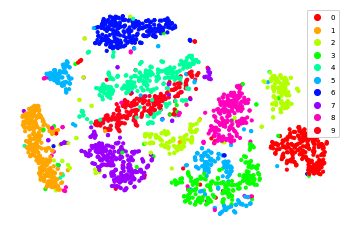

In [16]:
#Run original script parameters
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    Y = tsne_exp12(X, 2, 50, perplexity=30.0)
    fig, ax = plt.subplots()
    scatter = ax.scatter(Y[:, 0], Y[:, 1], s=10, c=labels, cmap='hsv')
    plt.axis('off')
    legend = ax.legend(*scatter.legend_elements(), fontsize=7)
    ax.add_artist(legend)
    plt.show()

In [17]:
#learning rate 250 from script(500) changed
def tsne_exp13(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000 #The number of gradient descent iterations T
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 250
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.573319
Iteration 10: error is 22.282260
Iteration 20: error is 20.774101
Iteration 30: error is 17.455966
Iteration 40: error is 16.273657
Iteration 50: error is 15.879227
Iteration 60: error is 15.680141
Iteration 70: error is 15.598626
Iteration 80: error is 15.558383
Iteration 90: error is 15.517847
Iteration 100: error is 15.493466
Iteration 110: error is 2.199483
Iteration 120: error is 1.944031
Iteration 130: error is 1.775250
Iteration 140: error is 1.656162
Iteration 150: error is 1.565984
Iteration 160: error is 1.495532
Iteration 170: error is 1.438612
It

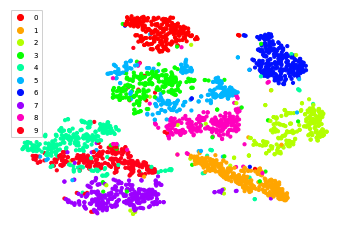

In [18]:
#Run original script parameters
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    Y = tsne_exp13(X, 2, 50, perplexity=30.0)
    fig, ax = plt.subplots()
    scatter = ax.scatter(Y[:, 0], Y[:, 1], s=10, c=labels, cmap='hsv')
    plt.axis('off')
    legend = ax.legend(*scatter.legend_elements(), fontsize=7)
    ax.add_artist(legend)
    plt.show()